In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
#raw_df = pd.read_csv('./generalAccuracy_combined.csv.bz2', index_col=0)
raw_df = pd.read_csv('./data/imdb-wiki_results/test2_rankCentrality_evaluated.csv')
raw_df['bias_applied'] = True
raw_df = raw_df.rename(columns={'sampling strategy': 'sampling method', 'recovery method': 'Ranking Method'})
raw_df

,trial,iteration,value,sampling method,Ranking Method,metric,group,bias_applied
0,0,90,0.209166,randomSampling,rankCentrality,tau,Privileged,True
1,0,90,0.212074,randomSampling,rankCentrality,tau,Unprivileged,True
2,0,90,0.094368,randomSampling,rankCentrality,exposure,Privileged,True
3,0,90,0.089440,randomSampling,rankCentrality,exposure,Unprivileged,True
4,0,90,0.215533,randomSampling,rankCentrality,tau,Privileged within-group,True
...,...,...,...,...,...,...,...,...
14968,7,1000,0.094627,rankSampling,rankCentrality,exposure,Privileged,True
14969,7,1000,0.089110,rankSampling,rankCentrality,exposure,Unprivileged,True
14970,7,1000,0.216066,rankSampling,rankCentrality,tau,Privileged within-group,True
14971,7,1000,0.202881,rankSampling,rankCentrality,tau,Between groups,True


In [8]:
sel_df = raw_df[raw_df.iteration == 500]
sel_df = sel_df.groupby(['iteration','bias_applied','sampling method','metric','group','Ranking Method']).mean().reset_index()
sel_df.loc[sel_df.metric == 'exposure', 'exposure'] = sel_df.value
sel_df.loc[sel_df.metric == 'tau', 'tau'] = sel_df.value
sel_df

,iteration,bias_applied,sampling method,metric,group,Ranking Method,trial,value,exposure,tau
0,500,True,oversampling,exposure,Privileged,rankCentrality,3.5,0.092043,0.092043,NaN
1,500,True,oversampling,exposure,Unprivileged,rankCentrality,3.5,0.092401,0.092401,NaN
2,500,True,oversampling,tau,Between groups,rankCentrality,3.5,0.179521,NaN,0.179521
3,500,True,oversampling,tau,Privileged,rankCentrality,3.5,0.178848,NaN,0.178848
4,500,True,oversampling,tau,Privileged within-group,rankCentrality,3.5,0.177791,NaN,0.177791
5,500,True,oversampling,tau,Unprivileged,rankCentrality,3.5,0.180115,NaN,0.180115
6,500,True,oversampling,tau,Unprivileged within-group,rankCentrality,3.5,0.181886,NaN,0.181886
7,500,True,randomSampling,exposure,Privileged,rankCentrality,3.5,0.094963,0.094963,NaN
8,500,True,randomSampling,exposure,Unprivileged,rankCentrality,3.5,0.088682,0.088682,NaN
9,500,True,randomSampling,tau,Between groups,rankCentrality,3.5,0.154960,NaN,0.154960


In [9]:
priv_df = sel_df[sel_df.group == 'Privileged'].drop(columns=['iteration', 'trial', 'value'])
unpriv_df = sel_df[sel_df.group == 'Unprivileged'].drop(columns=['iteration', 'trial', 'value'])
priv_df

,bias_applied,sampling method,metric,group,Ranking Method,exposure,tau
0,True,oversampling,exposure,Privileged,rankCentrality,0.092043,NaN
3,True,oversampling,tau,Privileged,rankCentrality,NaN,0.178848
7,True,randomSampling,exposure,Privileged,rankCentrality,0.094963,NaN
10,True,randomSampling,tau,Privileged,rankCentrality,NaN,0.155595
14,True,rankSampling,exposure,Privileged,rankCentrality,0.094549,NaN
17,True,rankSampling,tau,Privileged,rankCentrality,NaN,0.216047


In [10]:
ratio_df = pd.merge(left=priv_df, left_on=['bias_applied','sampling method','metric','Ranking Method'],
                    right=unpriv_df, right_on=['bias_applied','sampling method','metric','Ranking Method'],
                    suffixes=('_priv', '_unpriv'))
ratio_df = ratio_df.drop(columns=['group_priv', 'group_unpriv'])
ratio_df['exposure ratio'] = ratio_df.exposure_unpriv / ratio_df.exposure_priv  # higher is better
ratio_df['error ratio'] = ratio_df.tau_priv / ratio_df.tau_unpriv  # lower is better
ratio_df

,bias_applied,sampling method,metric,Ranking Method,exposure_priv,tau_priv,exposure_unpriv,tau_unpriv,exposure ratio,error ratio
0,True,oversampling,exposure,rankCentrality,0.092043,NaN,0.092401,NaN,1.003892,NaN
1,True,oversampling,tau,rankCentrality,NaN,0.178848,NaN,0.180115,NaN,0.992967
2,True,randomSampling,exposure,rankCentrality,0.094963,NaN,0.088682,NaN,0.933856,NaN
3,True,randomSampling,tau,rankCentrality,NaN,0.155595,NaN,0.162165,NaN,0.959485
4,True,rankSampling,exposure,rankCentrality,0.094549,NaN,0.089210,NaN,0.943534,NaN
5,True,rankSampling,tau,rankCentrality,NaN,0.216047,NaN,0.218869,NaN,0.987106


In [12]:
exp_df = ratio_df[ratio_df.metric == 'exposure']
tau_df = ratio_df[ratio_df.metric == 'tau']

overall_df = pd.merge(left=exp_df[['bias_applied','sampling method','Ranking Method', 'exposure ratio']],
                      left_on=['bias_applied','sampling method','Ranking Method'],
                      right=tau_df[['bias_applied','sampling method','Ranking Method', 'error ratio']],
                      right_on=['bias_applied','sampling method','Ranking Method'])

#tau_overall_df = sel_df[sel_df.group == 'Overall'].drop(columns=['iteration', 'metric', 'group', 'trial', 'exposure', 'value']).rename(columns={'tau': 'error'})
#overall_df = pd.merge(left=overall_df, left_on=['bias_applied','sampling method','Ranking Method'],
#                      right=tau_overall_df, right_on=['bias_applied','sampling method','Ranking Method'])

overall_df

,bias_applied,sampling method,Ranking Method,exposure ratio,error ratio
0,True,oversampling,rankCentrality,1.003892,0.992967
1,True,randomSampling,rankCentrality,0.933856,0.959485
2,True,rankSampling,rankCentrality,0.943534,0.987106


In [19]:
overall_df = overall_df.replace({'OversampleMinority': 'Oversampling',
                                 'oversampling': 'Oversampling',
                                 'RankSampling': 'Rank-Based Sampling',
                                 'rankSampling': 'Rank-Based Sampling',
                                 'RandomSampling': 'Random Sampling',
                                 'randomSampling': 'Random Sampling',
                                 'fairPageRank': 'Fairness-Aware PageRank',
                                 'davidScore': "David's Score",
                                 'randomRankRecovery': 'Random Rank Recovery',
                                 'rankCentrality': 'Rank Centrality'})

overall_df = overall_df.rename(columns={'sampling method': 'Sampling Method'})

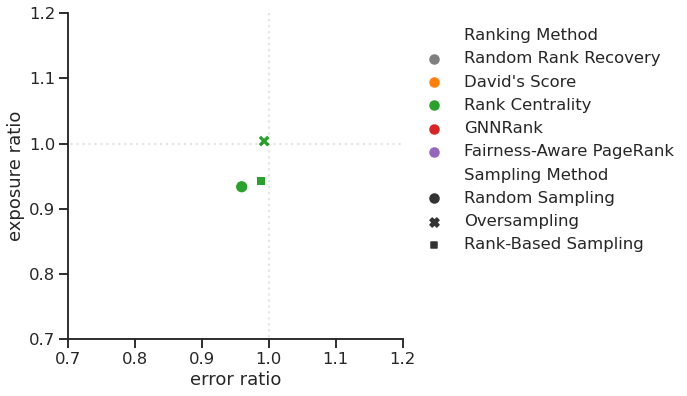

In [23]:
palette = sns.color_palette('tab10')
palette[0] = palette[7]
sns.set(rc={'figure.figsize':(6,6)})
sns.set_context("talk") # larger font size
sns.set_style('ticks')

df = overall_df[(overall_df.bias_applied)].copy()# & (overall_df['Sampling Method'] == 'Random Sampling')]
#df['exposure ratio'] = df['exposure ratio'] + np.random.normal(0,0.001,len(df))
#df['error ratio'] = df['error ratio'] + np.random.normal(0,0.001,len(df))
#df['error'] = df['error'] + np.random.normal(0,0.001,len(df))

with sns.color_palette(palette):
    ax = sns.scatterplot(df, x='error ratio', y='exposure ratio', hue='Ranking Method', s=150, style='Sampling Method',
                         hue_order=['Random Rank Recovery', "David's Score", 'Rank Centrality', 'GNNRank', 'Fairness-Aware PageRank'],
                         style_order=['Random Sampling', 'Oversampling', 'Rank-Based Sampling'])
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1), frameon=False)
ax.set(xlim=(0.7,1.2), ylim=(0.7,1.2))
plt.plot([0,2], [1,1], color='black', linestyle='dotted', alpha=0.1)
plt.plot([1,1], [0,2], color='black', linestyle='dotted', alpha=0.1)
sns.despine()